In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
from ast import literal_eval
import networkx as nx
import folium
import time
import warnings
import pickle
import sys
import json
import neptune

warnings.filterwarnings('ignore')
print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
# import modules
import visualize
import geometry_utils
from maritime_traffic_network import MaritimeTrafficNetwork
import prediction_model_evaluation_metrics as metrics

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# path to directory of model
location = 'tromso'
path_format = 'node2node'
directory = '../../models/gretel_prediction_models/'+location+'_small/'+path_format+'/'
# load metadata from file
with open(directory+'/metadata.json', 'r') as json_file:
    meta_dict = json.load(json_file)
meta_dict

{'network_name': '202204_waypoints_DP10_HDBSCAN13_tromso_full_UTM',
 'n_points': 796177,
 'n_nodes': 541,
 'n_edges': 2139,
 'training_dates': "['202205']",
 'n_training_paths': 1433,
 'node_features': "['n_members']",
 'egde_features': "['length', 'weight', 'direction']",
 'path_format': 'node2node',
 'lr': 0.0005,
 'loss': 'target_only',
 'n_epochs': 30,
 'target_prediction': 'next',
 'model_type': 'Gretel',
 'test_dates': "['202206']",
 'selection_start': 0,
 'selection_end': 1521,
 'selection_step': 2,
 'n_test_paths': 761,
 'n_walks': 500}

In [3]:
# set parameters for prediction
prediction_task = 'path'
eval_mode = 'path'
n_start_nodes=1
network_name = meta_dict['network_name']
test_dates = literal_eval(meta_dict['test_dates'])

In [4]:
# load maritime traffic network
network_path = '../../models/networks/best_networks/' + network_name + '.obj'
fileObj = open(network_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 13,
 'clustering_min_cluster_size': 13,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [5]:
# Load test data for prediction model
for i in range(0, len(test_dates)):
    test_date = test_dates[i]
    # Load path data
    filename = network_name+'_'+test_date+'_paths.csv'
    test_data = pd.read_csv('../../data/paths/'+filename)
    test_data['path'] = test_data['path'].apply(literal_eval)
    test_data = gpd.GeoDataFrame(test_data, geometry=gpd.GeoSeries.from_wkt(test_data['geometry']), crs=network.crs)
    test_data = test_data[test_data['message']=='success']

    # Load respective trajectories for evaluation
    traj_file = test_date+'_points_'+location+'_cleaned_meta_full_dualSplit_2'
    filename = '../../data/processed/' + traj_file + '.parquet'
    traj_gdf = gpd.read_parquet(filename)
    traj_gdf.to_crs(network.crs, inplace=True)  # Transformation
    
    if i==0:
        all_test_data = test_data
        all_traj_gdf = traj_gdf
    else:
        all_test_data = pd.concat([all_test_data, test_data])
        all_traj_gdf = pd.concat([all_traj_gdf, traj_gdf])
        
test_trajectories = mpd.TrajectoryCollection(all_traj_gdf, traj_id_col='mmsi', obj_id_col='mmsi')

In [6]:
# load predictions from file
predictions = pd.read_csv(directory+'predictions.csv')
predictions['ground_truth'] = predictions['ground_truth'].apply(literal_eval)
predictions['prediction'] = predictions['prediction'].apply(literal_eval)

In [7]:
# check if all predictions are valid
for index, row in predictions.iterrows():
    if geometry_utils.is_valid_path(network.G, row['ground_truth']) == False:
        print(row['mmsi'].tolist())

https://app.neptune.ai/jandrik91/RoutePredictions/e/ROUT-91
Evaluating 756 samples for path prediction task
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Time elapsed: 0.61 minutes


Percentage of unsuccessful predictions: 0.00%
Mean SSPD: 272.31m
Median SSPD: 53.77m
Mean choice_accuracy: 0.6618


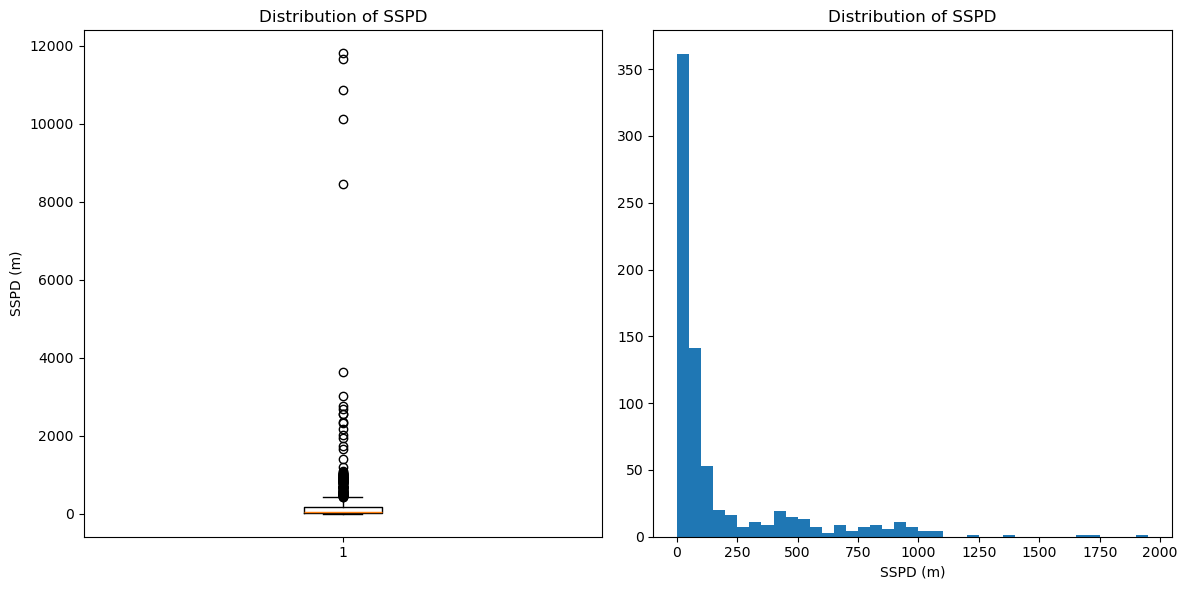

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 40 operations to synchronize with Neptune. Do not kill this process.
All 40 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/jandrik91/RoutePredictions/e/ROUT-91/metadata


In [8]:
run = neptune.init_run(
    project="jandrik91/RoutePredictions",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYmQzMjgwZS1jZGYwLTQ2YjktYWNjOS02MjBlZWEzNzUzNDcifQ==",
)  # your credentials

# evaluate
evaluation_results, fig = metrics.evaluate_given_predictions(prediction_task, predictions, test_trajectories, 
                                                             network, n_start_nodes=n_start_nodes, eval_mode=eval_mode)

nan_mask = evaluation_results.isna().any(axis=1)
failure_rate = nan_mask.sum() / len(evaluation_results)
mean_abs_err = np.mean(evaluation_results[~nan_mask]["SSPD"])
median_abs_err = np.median(evaluation_results[~nan_mask]["SSPD"])
choice_accuracy = np.mean(evaluation_results[~nan_mask]["choice_accuracy"])

# save experiment
run["network_name"] = network_name
run["n_points"]=len(network.gdf)
run["n_nodes"]=network.G.number_of_nodes()
run["n_edges"]=network.G.number_of_edges()

params = network.hyperparameters
params['clustering_metric_V_coord'] = params['clustering_metric_V'][0][0]
params['clustering_metric_V_cog'] = params['clustering_metric_V'][2][2]
params['clustering_metric_V_speed'] = params['clustering_metric_V'][4][4]
run["network_parameters"] = params

run["training_data"] = {'training_dates':meta_dict['training_dates'],
                        'n_training_paths':meta_dict['n_training_paths']}

run["test_data"] = {'test_dates':str(test_dates),
                    'selection_start':meta_dict['selection_start'],
                    'selection_end':meta_dict['selection_end'],
                    'selection_step':meta_dict['selection_step'],
                    'n_test_paths':meta_dict['n_test_paths']}

run["prediction_task"] = prediction_task
run["eval_mode"] = eval_mode
run["model_type"] = meta_dict['model_type']
run["n_start_nodes"] = n_start_nodes

run['node_features'] = meta_dict['node_features']
run['egde_features'] = meta_dict['egde_features']
run['path_format'] = meta_dict['path_format']
run['lr'] = meta_dict['lr']
run['loss'] = meta_dict['loss']
run['n_epochs'] = meta_dict['n_epochs']
run['MOGen_n_walks'] = meta_dict['n_walks']
run['target_prediction'] = meta_dict['target_prediction']

run["plot"].upload(fig)
run["failure_rate"] = failure_rate
run["mean_abs_err"] = mean_abs_err
run["median_abs_err"] = median_abs_err
run["choice_accuracy"] = choice_accuracy

run.stop()